In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

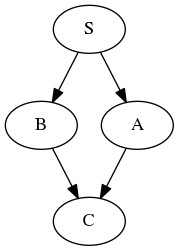

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
def calculate_response(stim_times, source, target, winsize, latency, time_shift=15):
    src = np.searchsorted
    result = {
        'stim_response': (
            # stim response
            src(source, stim_times, 'left') <
            src(source, stim_times + winsize, 'right')),
        'no_stim_response': (
            # stim response
            src(source, stim_times - time_shift, 'left') <
            src(source, stim_times - time_shift + winsize, 'right')),
        'syn_response': (
            # stim synaptic response
            src(target, stim_times + latency, 'left') <
            src(target, stim_times + latency + winsize, 'right')),
        'no_stim_syn_response': (
            # stim response
            src(target, stim_times - time_shift + latency, 'left') <
            src(target, stim_times - time_shift + latency + winsize, 'right')),
    }
    return result


def wald(stim_times, source, target, winsize, latency):
    """The IV estimator used in the paper"""
    responses = calculate_response(
        stim_times, source, target, winsize, latency)
    z_s1_x0 = responses['stim_response'] == 0
    z_s1_x1 = z_s1_x0 == False
    
    y_s1_x0 = responses['syn_response'][z_s1_x0]
    y_s1_x1 = responses['syn_response'][z_s1_x1]
    
    y_s1 = (y_s1_x1.mean() - y_s1_x0.mean()) / (z_s1_x1.mean() - z_s1_x0.mean())
    
    z_s0_x0 = responses['no_stim_response'] == 0
    z_s0_x1 = z_s0_x0 == False
    
    y_s0_x0 = responses['no_stim_syn_response'][z_s0_x0]
    y_s0_x1 = responses['no_stim_syn_response'][z_s0_x1]
    
    y_s0 = (y_s0_x1.mean() - y_s0_x0.mean()) / (z_s0_x1.mean() - z_s0_x0.mean())
    return y_s1, y_s0, y_s1 - y_s0

In [5]:
results = defaultdict(list)
amps = np.arange(0, 3.1, .1)
winsize, latency = 4, 4
for a in amps:
    data = simulate(par, stim_N=10000, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
    t_stop = data['status']['time']
    A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    stim_times = data['epoch']['times']
    
    beta_AC, beta_ACr, beta_AC_corrected = wald(stim_times, A_spikes, C_spikes, winsize, latency)
    beta_BC, beta_BCr, beta_BC_corrected = wald(stim_times, B_spikes, C_spikes, winsize, latency)
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)    
    results['beta_ACr'].append(beta_ACr)    
    results['beta_BCr'].append(beta_BCr)    
    results['beta_ACc'].append(beta_AC_corrected)    
    results['beta_BCc'].append(beta_BC_corrected)
    results['rate_A'].append(len(A_spikes) / data['status']['time'] * 1000)
    results['rate_B'].append(len(B_spikes) / data['status']['time'] * 1000)
    results['rate_C'].append(len(C_spikes) / data['status']['time'] * 1000)

simulating  425625.0
stimulating  10000
simulating  425565.0
stimulating  10000
connecting  J_AC 0.1
simulating  425237.0
stimulating  10000
connecting  J_AC 0.2
simulating  425095.0
stimulating  10000
connecting  J_AC 0.30000000000000004
simulating  425942.0
stimulating  10000
connecting  J_AC 0.4
simulating  423258.0
stimulating  10000
connecting  J_AC 0.5
simulating  425202.0
stimulating  10000
connecting  J_AC 0.6000000000000001
simulating  425058.0
stimulating  10000
connecting  J_AC 0.7000000000000001
simulating  426449.0
stimulating  10000
connecting  J_AC 0.8
simulating  426200.0
stimulating  10000
connecting  J_AC 0.9
simulating  426440.0
stimulating  10000
connecting  J_AC 1.0
simulating  425830.0
stimulating  10000
connecting  J_AC 1.1
simulating  425192.0
stimulating  10000
connecting  J_AC 1.2000000000000002
simulating  424449.0
stimulating  10000
connecting  J_AC 1.3
simulating  425672.0
stimulating  10000
connecting  J_AC 1.4000000000000001
simulating  424109.0
stimulati

In [6]:
results = {k: np.array(v) for k, v in results.items()}

Text(0.5,1,'BC')

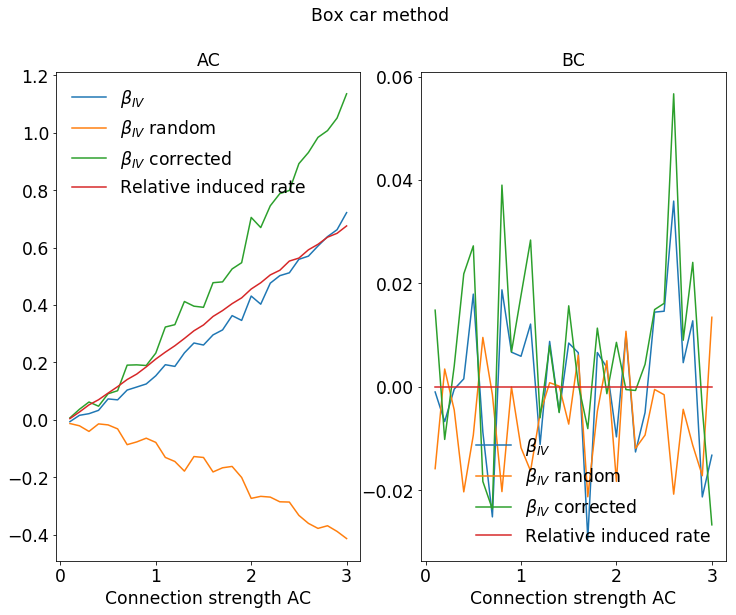

In [7]:
fig, (axa, axb) = plt.subplots(1,2)

plt.suptitle('Box car method', fontsize='xx-large')

axa.plot(amps[1:], results['beta_AC'][1:], label=r'$\beta_{IV}$')
axa.plot(amps[1:], results['beta_ACr'][1:], label=r'$\beta_{IV}$ random')
axa.plot(amps[1:], results['beta_ACc'][1:], label=r'$\beta_{IV}$ corrected')
axa.plot(amps[1:], results['rate_C'][1:] / results['rate_C'][0] - 1, label='Relative induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps[1:], results['beta_BC'][1:], label=r'$\beta_{IV}$')
axb.plot(amps[1:], results['beta_BCr'][1:], label=r'$\beta_{IV}$ random')
axb.plot(amps[1:], results['beta_BCc'][1:], label=r'$\beta_{IV}$ corrected')
axb.plot(amps[1:], np.zeros_like(amps[1:]), label='Relative induced rate')
axb.legend(frameon=False, loc=4)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')